In [42]:
import pandas as pd
import numpy as np
import datetime
from IPython import display
from dateutil.parser import parse

from rl4pm_lib.utils_supervised import make_window_features

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb

import matplotlib.pyplot as plt

In [47]:
test_df = pd.read_csv('datasets/test_df.csv')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: parse(x))

train_df = pd.read_csv('datasets/train_df.csv')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: parse(x))

## Proprocessing:
### 1. Make features
For leveraging predictive models the following features are created:
- $t_e$ - time since previous event
- $t_w$ - time since the beginning of week
- $t_t$ - time since the beginning of trace
- one hot encoded labels

### 2. Make window with lags

### 3. Scale it

In [3]:
import rl4pm_lib.preprocessing as preprocessing
# make features
column_feature = {'tt': 0, 'te': 1, 'tw': 2}
# prepro = preprocessing.DfPreprocesser()
# prepro.fit(train_df)
# train_df_pr = prepro.transform(train_df)
# test_df_pr = prepro.transform(test_df)

In [ ]:
# test_df_pr

In [4]:
win_len = 2

# test_df_pr_win, test_labels, test_tes = make_window_features(train_df_pr, win_len)

# train_df_pr_win, train_labels, train_tes = make_window_features(train_df_pr, win_len)

The data above can be just writed to disk so it is fixed

In [ ]:
# to_write_win_test = test_df_pr_win
# to_write_win_test['labels'] = test_labels
# to_write_win_test['te_true'] = test_tes

# to_write_win_train = train_df_pr_win
# to_write_win_train['labels'] = train_labels
# to_write_win_train['te_true'] = train_tes

# to_write_win_test.to_csv(f'datasets/test_features_win_{win_len}.csv', index=False)
# to_write_win_train.to_csv(f'datasets/train_features_win_{win_len}.csv', index=False)

In [5]:
test_df_pr_win = pd.read_csv(f'datasets/test_features_win_{win_len}.csv')
train_df_pr_win = pd.read_csv(f'datasets/train_features_win_{win_len}.csv')

if 'timestamp' in test_df_pr_win:
    test_df_pr_win['timestamp'] = test_df_pr_win['timestamp'].apply(lambda x: parse(x))
if 'timestamp' in train_df_pr_win:
    train_df_pr_win['timestamp'] = train_df_pr_win['timestamp'].apply(lambda x: parse(x))
    
test_df_pr_win.sort_values(by=['timestamp'], inplace=True)
train_df_pr_win.sort_values(by=['timestamp'], inplace=True)

test_labels, test_tes = test_df_pr_win['labels'], test_df_pr_win['te_true']
test_df_pr_win = test_df_pr_win.drop(columns=['labels', 'te_true'])

train_labels, train_tes = train_df_pr_win['labels'], train_df_pr_win['te_true']
train_df_pr_win = train_df_pr_win.drop(columns=['labels', 'te_true'])

In [6]:
activities = []
_d = train_df_pr_win.copy()
for _c in _d.columns:
    if (_c[:2] == 'W_') and ('__' not in _c):
        activities.append(_c)
activities

['W_Afhandelen leads',
 'W_Beoordelen fraude',
 'W_Completeren aanvraag',
 'W_Nabellen incomplete dossiers',
 'W_Nabellen offertes',
 'W_Valideren aanvraag']

In [7]:
if ('timestamp' in train_df_pr_win) and (type(train_df_pr_win['timestamp'].values[0])==str):
    train_df_pr_win['timestamp'] = train_df_pr_win['timestamp'].apply(lambda x: parse(x))
if ('timestamp' in test_df_pr_win) and (type(test_df_pr_win['timestamp'].values[0])==str):
    test_df_pr_win['timestamp'] = test_df_pr_win['timestamp'].apply(lambda x: parse(x))

Also must scale continious (time related features)

In [8]:
train_df_pr_win.shape, train_labels.shape

((43574, 20), (43574,))

In [9]:
from rl4pm_lib.preprocessing import PaperScalerPd as PaperScaler

Let's construct features as moving window

Ok, features and targets are ready, let's do `.fit()`, `.predict())))))`

What methods will I use? Of course all, which were listed [here](https://github.com/lemikhovalex/DA_CV)

## PipeLine

In [10]:

pipe = Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfc', RandomForestClassifier(n_estimators=30, max_depth=4, random_state=42, n_jobs=-1))
                ])

In [ ]:
pipe.fit(train_df_pr_win.drop(columns=['timestamp']), train_labels)

# Classification
## Random Forest Classifier

In [ ]:

splitter = TimeSeriesSplit(n_splits=7)
xs = splitter.split(train_df_pr_win, train_labels)

In [ ]:
%%time
pipe = Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfc', RandomForestClassifier(n_estimators=30, max_depth=4, random_state=42, n_jobs=-1))
                ])

pipe.fit(train_df_pr_win, train_labels)
train_labels_hat = pipe.predict(train_df_pr_win)
test_labels_hat = pipe.predict(test_df_pr_win)

test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(train_labels_hat, train_labels)
print(f'Random Forest Classifier\ntest  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')

print(f'test  f1 = {get_f1_score(test_labels_hat, test_labels): .2f}')
print(f'train f1 = {get_f1_score(train_labels_hat, train_labels): .2f}')

In [ ]:
%%time
param_grid = { 
    'rfc__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfc__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs = Pipeline([('scaler', PaperScaler(column_feature)),
                     ('rfc', RandomForestClassifier(random_state=42, class_weight='balanced'))
                    ])
CV_rfc = GridSearchCV(estimator=model_gs, param_grid=param_grid, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_rfc.fit(train_df_pr_win, train_labels)

In [ ]:
CV_rfc.best_params_

In [ ]:
rfc_activ_best = CV_rfc.best_estimator_

In [38]:
rfc_activ_best = Pipeline([('scaler', PaperScaler(column_feature)),
                            ('rfc', RandomForestClassifier(random_state=42, 
                                                           max_depth=18,
                                                           n_estimators=218
                                                          ))
                           ])

In [44]:
%%time

rfc_activ_best.fit(train_df_pr_win, train_labels)

train_labels_hat = rfc_activ_best.predict(train_df_pr_win)
test_labels_hat = rfc_activ_best.predict(test_df_pr_win)

test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(train_labels_hat, train_labels)

print(f'Random Forest Classifier, after grid search')
print(f'test  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')
print(f'test  f1 = {f1_score(test_labels, test_labels_hat, average="weighted"): .2f}')
print(f'train f1 = {f1_score(train_labels, train_labels_hat, average="weighted"): .2f}')

Random Forest Classifier, after grid search
test  accuracy =  0.94
train accuracy =  0.94
test  f1 =  0.93
train f1 =  0.93
Wall time: 19 s


In [ ]:

cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('RFC\nConfusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [ ]:

cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('RFC\nConfusion matrix as probabilities')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [ ]:
test_labels_hat

Resuls some how are beter then in article on LSTM approach

## K Neighbors Classifier

In [ ]:
%%time
grid_knn = { 
    'knn__n_neighbors': np.linspace(3, 30, 6, dtype=int),
    'knn__weights' : ['distance', 'uniform'],
}

model_gs_knn = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('knn', KNeighborsClassifier())
                        ])
CV_knn = GridSearchCV(estimator=model_gs_knn, param_grid=grid_knn, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=10, verbose=1)
CV_knn.fit(train_df_pr_win, train_labels)

print(CV_knn.best_score_)
print(CV_knn.best_params_)

Ok, next

## Grad Boost

In [ ]:
%%time
param = {'objective': 'multi:softprob',  # error evaluation for multiclass training
         'num_class': 6,
         'tree_method': 'gpu_hist',

        }

grid_xgb = {'xgb__max_depth': np.linspace(5, 10, num=5, dtype=int),
            'xgb__n_estimators': np.linspace(3, 10, num=7, dtype=int),
            'xgb__eta': np.linspace(0.001, 0.3, num=20, dtype=float)
           }

model_gs_xgb = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgb', xgb.XGBClassifier(**param))
                        ])
CV_xgb = GridSearchCV(estimator=model_gs_xgb, param_grid=grid_xgb, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_xgb.fit(train_df_pr_win, train_labels)

print(CV_xgb.best_score_)
print(CV_xgb.best_params_)

In [ ]:
xgb_clf_best = CV_xgb.best_estimator_

In [45]:
xgb_clf_best = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgb', xgb.XGBClassifier(objective='multi:softprob',
                                                   num_class=6,
                                                   tree_method='gpu_hist',
                                                   max_depth=8,
                                                   n_estimators=10
                                                  )
                         )]
                       )

In [46]:
xgb_clf_best.fit(train_df_pr_win, train_labels)

train_labels_hat = xgb_clf_best.predict(train_df_pr_win)
test_labels_hat = xgb_clf_best.predict(test_df_pr_win)

test_acc_xgb = accuracy_score(test_labels_hat, test_labels)
train_acc_xgb = accuracy_score(train_labels_hat, train_labels)

print(f'XG boost Classifier')
print(f'test  accuracy = {test_acc_xgb: .2f}\ntrain accuracy = {train_acc_xgb: .2f}')

print(f'test  f1 = {f1_score(test_labels, test_labels_hat, average="weighted"): .2f}')
print(f'train f1 = {f1_score(train_labels, train_labels_hat, average="weighted"): .2f}')

XG boost Classifier
test  accuracy =  0.85
train accuracy =  0.85
test  f1 =  0.84
train f1 =  0.84


In [ ]:
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('XG boost Classifier\nConfusion matrix XGB')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [ ]:
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('XG boost Classifier\nConfusion matrix XGB')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## Classification results
Classique approaches povides results, which outperforms result, given in article as baseline, but...

- As been shown in visualization, there are a lot of loops, model that doesnt consern information on all the trail seems to be useless for end time prediction
- Accuracy is what been used for benchmarking in papers. Maybe it is not the best metric? Who knows, nevertheless this is a bench

# Regression

In [52]:
%%time
param_grid_rfr = { 
    'rfr__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfr__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs_reg = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('rfr', RandomForestRegressor(random_state=42))
                        ])
CV_rfr = GridSearchCV(estimator=model_gs_reg, param_grid=param_grid_rfr, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_rfr.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 750 out of 750 | elapsed: 42.0min finished


Wall time: 42min 24s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x000001D92B5C90D0>),
                                       ('rfr',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=6,
             param_grid={'rfr__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 20]),
                         'rfr__n_estimators': array([140, 147, 155, 163, 171, 179, 187, 195, 202, 210, 218, 226, 234,
       242, 250])},
             scoring='neg_mean_absolute_error', verbose=1)

In [53]:
CV_rfr.best_params_

{'rfr__max_depth': 10, 'rfr__n_estimators': 163}

In [ ]:
rfr =  Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfr', RandomForestRegressor(random_state=42,
                                               n_estimators=163,
                                               max_depth=10
                                              ))
                        ])

In [54]:
rfr = CV_rfr.best_estimator_
rfr.fit(train_df_pr_win, train_tes)
train_tes_hat_rfr = rfr.predict(train_df_pr_win)
test_tes_hat_rfr = rfr.predict(test_df_pr_win)

test_mae_xgb = MAE(test_tes_hat_rfr, test_tes) / 3600. / 24
train_mae_xgb = MAE(train_tes_hat_rfr, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_xgb: .2f}, days\ntrain MAE = {test_mae_xgb: .2f}, days')

Random Forest Regression
MAE  accuracy =  1.62, days
train MAE =  1.62, days


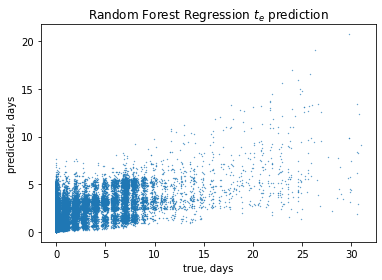

In [55]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_rfr / 3600. / 24, s=0.1)
plt.title('Random Forest Regression $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

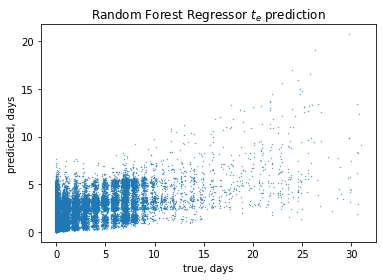

In [56]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_rfr / 3600. / 24, s=0.1)
plt.title('Random Forest Regressor $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

[]

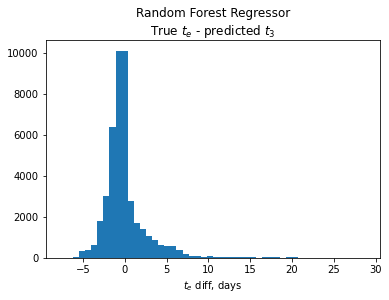

In [57]:
plt.hist((test_tes - test_tes_hat_rfr) / 3600. / 24, bins=50)
plt.xlabel('$t_e$ diff, days')
plt.title('Random Forest Regressor\nTrue $t_e$ - predicted $t_3$')
plt.plot()

## Dull

In [60]:
te_dull = train_tes.mean()
test_dull = te_dull * np.ones(test_tes.shape)
train_dull = te_dull * np.ones(train_tes.shape)

test_mae_dull = MAE(test_dull, test_tes) / 3600. / 24
train_mae_dull = MAE(train_dull, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_dull: .2f}, days\ntrain MAE = {test_mae_dull: .2f}, days')

Random Forest Regression
MAE  accuracy =  2.20, days
train MAE =  2.20, days


Again better then papers)

In [ ]:
def huber_approx_obj(preds, dtrain):
    '''
    https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function
    '''
    d = preds - dtrain.get_labels() #remove .get_labels() for sklearn
    h = 1  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

In [14]:
param = {'tree_method': 'gpu_hist'
        }

grid_xgbr = {'xgbr__max_depth': np.linspace(5, 10, num=5, dtype=int),
            'xgbr__n_estimators': np.linspace(3, 10, num=7, dtype=int),
            'xgbr__eta': np.linspace(0.001, 0.3, num=20, dtype=float)
           }

model_gs_xgbr = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgbr', xgb.XGBClassifier(**param))
                        ])
CV_xgbr = GridSearchCV(estimator=model_gs_xgbr, param_grid=grid_xgbr, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_xgbr.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
exception calling callback for <Future at 0x1d91a1c0190 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 366, in __call__
    self.parallel.dispatch_next()
  File "c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 799, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\joblib\parallel.py", line 784, in _dispatch
    job = se

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
CV_xgbr.best_params_

In [ ]:
xgbr = CV_xgbr.best_estimator_
xgbr.fit(train_df_pr_win, train_tes)
train_tes_hat_xgbr = xgbr.predict(train_df_pr_win)
test_tes_hat_xgbr = xgbr.predict(test_df_pr_win)

test_mae_xgbr = MAE(test_tes_hat_xgbr, test_tes) / 3600. / 24
train_mae_xgbr = MAE(train_tes_hat_xgbr, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_xgbr: .2f}, days\ntrain MAE = {test_mae_xgbr: .2f}, days')

In [ ]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_xgbr / 3600. / 24, s=0.1)
plt.title('Random Forest Regressor $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

XGB is not that cool

In [ ]:

grid_ridge = {'ridge__alpha': np.linspace(1., 30., num=200, dtype=float)
             }

model_gs_ridge = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('ridge', Ridge())
                        ])
CV_ridge = GridSearchCV(estimator=model_gs_ridge, param_grid=grid_ridge, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_ridge.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.0min


In [29]:
CV_ridge.best_params_

{'ridge__alpha': 8.140703517587939}

In [30]:
ridge = CV_ridge.best_estimator_
ridge.fit(train_df_pr_win, train_tes)
train_tes_hat_ridge = ridge.predict(train_df_pr_win)
test_tes_hat_ridge = ridge.predict(test_df_pr_win)

test_mae_ridge = MAE(test_tes_hat_ridge, test_tes) / 3600. / 24
train_mae_ridge = MAE(train_tes_hat_ridge, train_tes) / 3600. / 24

print(f'Random Forest Regression')
print(f'MAE  accuracy = {test_mae_ridge: .2f}, days\ntrain MAE = {test_mae_ridge: .2f}, days')

Random Forest Regression
MAE  accuracy =  1.87, days
train MAE =  1.87, days


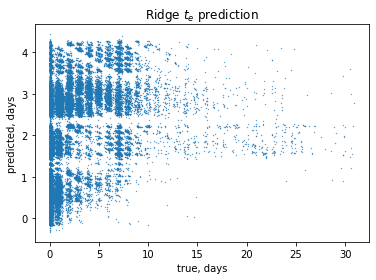

In [31]:
plt.scatter(test_tes / 3600. / 24, test_tes_hat_ridge / 3600. / 24, s=0.1)
plt.title('Ridge $t_e$ prediction')
plt.xlabel('true, days')
plt.ylabel('predicted, days')
plt.show()

[]

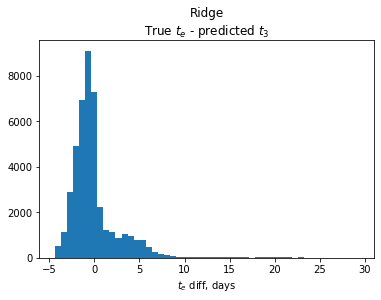

In [35]:
plt.hist((test_tes - test_tes_hat_ridge) / 3600. / 24, bins=50)
plt.xlabel('$t_e$ diff, days')
plt.title('Ridge\nTrue $t_e$ - predicted $t_3$')
plt.plot()

# No long activity!